## 1. Data Description

This project uses data collected by the UBC Minecraft Research Group. 
The datasets are `players.csv`(player characteristics) and `sessions.csv`(individual sessions).
The question focuses on predicting newsletter subscription status, so only `players.csv` is needed.
`players.csv`
- 196 players
- 7 variables

Each row gives if the player has subscribed or not (TRUE if subscribed).
Variables of interest in `players.csv`:
- subscribe(TRUE if subscribed, logical)
- experience (one of: Amateure, Beginner, Regular, Pro, Advanced, Veteren; categorical)
- played_hours (total hours played, numeric)
- gender (categorical: Male, Female, Prefer not to say, Non-binary, Two-spirit, Agender) 
- Age (numeric)




In [48]:
# loading packages and datasets
library(tidyverse)
library(janitor)

set.seed(111)

players <- read_csv("players.csv") |>
clean_names()

glimpse(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashed_email <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


In [49]:
# Summary Stats
players_means <- players |>
    select(where(is.numeric)) |>
    summarise(across(everything(), ~ round(mean(.x, na.rm = TRUE), 2))) |>
    pivot_longer(
        cols = everything(), 
        names_to = "Variable", 
        values_to = "Mean")

players_means

Variable,Mean
<chr>,<dbl>
played_hours,5.85
age,21.14


## 2. Questions

- **Broad question chosen**: Question 1 
- **Specific predictive question**:  
  Which player characteristics, if any, best predict whether a player subscribes to the newsletter?

- **Response variable**: `subscribe` (TRUE or FALSE).
- **Explanatory variables**:
  - `experience` (categorical)
  - `played_hours`(numeric)
  - `gender` (categorical)
  - `age`(numeric)


Each row in `players.csv` contains all variables above, unique to each player. So all relevent data is here and no additional data wrangling required.

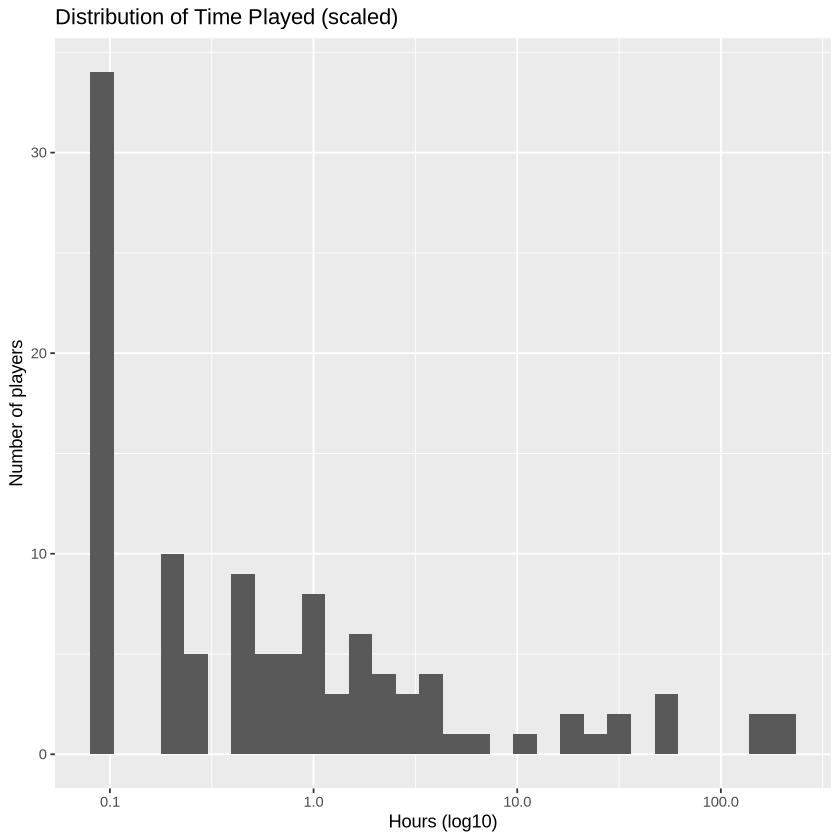

In [50]:
# Distribution of played_hours plot
players |>
    filter(!is.na(played_hours), played_hours > 0) |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 30) +
    scale_x_log10() +
    labs(
        title = "Distribution of Time Played (scaled)",
        x = "Hours (log10)",
        y = "Number of players"
  )

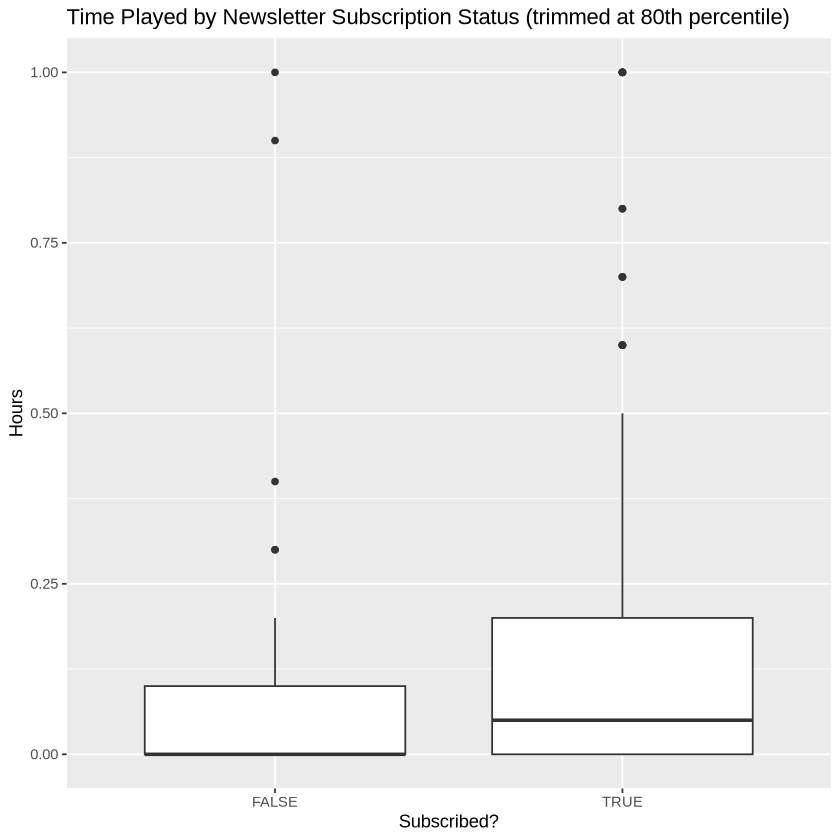

In [51]:
#Plot of played_hours vs subscribe
players |>
    filter(!is.na(subscribe), !is.na(played_hours)) |>
    filter(played_hours <= quantile(played_hours, 0.8, na.rm = TRUE)) |>
    ggplot(aes(x = subscribe, y = played_hours)) +
    geom_boxplot() +
    labs(
        title = "Time Played by Newsletter Subscription Status (trimmed at 80th percentile)",
        x = "Subscribed?",
        y = "Hours"
    )

## 3. Exploratory Data Analysis

Distribution of time played:
- Extremely right skewed. Most players have very low playtime, and few players having much more playtime. Log scale had to be used to visualize the distributions shape clearer.
Most players had less than one hour of player. Long right tail indicates few players with significantly higher play time. This skew suggests transforming may be needed for modeling.

Time Played by Newsletter Subscription Status:
- Subscribers have generally higher (slightly) playing time that non-subscribers. 
The median for both groups is close to zero hours. Subscribed players do have greater median, 75th quartile, and more and greater outliers. These outliers were trimmed from the plot so that the quantiles between the two groups could be better compared. 
This skew suggests that playtime may be, in someway, able to weakly predict subscription status. 




## 4. Methods and Plan

**Method:**
K-Nearest Neighbors (knn) classification to predict player subscription to newsletter (`subscribe`) using player charachteristics (`experience`, `played_hours`, `gender`, `age`).

**Why appropriate:**
- good for non-linear relationship (`played_hours`)
- incorporates numeric (`played_hours`, `age`) and  categorical (`experience`,`gender`)

**Required assumptions:**
- Categorical variables can be converted to numeric and retain meaning
- Not too many categories for categorical variables
- Unit scales will be comparable

**Potential limitations:**
- Outlier sensitivity (`played_hours`)
- Skew sensitivity (`played_hours`)
- Unit Scale sensitivity 
- Sensitive to value of K chosen

**Data**
- `player.csv` data
- turn categorical variables to numeric
- Standardize/scale numeric variables
- Possible transform skewed variables (log10)
- Possibly remove outliers
- remove rows with missing values
  
**Model:**
- Stratified split using `subscribe` for balance in sets.
- Split into training (70%) and testing (30%)
- This split will be done after cleaning data
- 5-fold cross-validation for training set to choose best K-value
- No validation set
